In [1]:
import numpy as np
import pandas as pd
from pyspark.sql import SparkSession

import plotly.express as px

import matplotlib.pyplot as plt
import matplotlib as mpl
import colorcet as cc

### Useful Constants, Setup, etc.

In [2]:
# list of US states
state_names = ["Alabama","Alaska","Arizona","Arkansas","California","Colorado","Connecticut","Delaware","Florida","Georgia","Hawaii","Idaho","Illinois",
               "Indiana","Iowa","Kansas","Kentucky","Louisiana","Maine","Maryland","Massachusetts","Michigan","Minnesota","Mississippi","Missouri","Montana",
               "Nebraska","Nevada","New Hampshire","New Jersey","New Mexico","New York","North Carolina","North Dakota","Ohio","Oklahoma","Oregon","Pennsylvania",
               "Rhode Island","South Carolina","South Dakota","Tennessee","Texas","Utah","Vermont","Virginia","Washington","West Virginia","Wisconsin","Wyoming"]

# function for pulling out states
isState = np.vectorize(lambda x: x in state_names)

# set plotsize and style
plt.rcParams['figure.figsize'] = 16, 5
mpl.style.use('ggplot')

### Load Data

In [3]:
# functions for automating DataFrame creations
def colRename(df):
    """Renames columns for easier indexing"""
    rename = {'Province/State': 'state', 'Country/Region': 'country', 'Lat': 'lat', 'Long': 'long'}
    return df.rename(columns=rename)

def dropUSCounties(df):
    """Drops US County data (it's empty, so I don't know why it's included...)"""
    rm_comma = np.vectorize(lambda x: x==x.replace(',', ''))
    non_counties = np.vectorize(lambda x: x not in ['Virgin Islands, U.S.', 'Washington, D.C.'])
    temp = df[pd.isna(df.state) == False]
    return temp[(rm_comma(temp.state)) & ((temp.state != 'Virgin Islands, U.S.') | (temp.state != 'New Castle, DE'))]

def byCountry(df):
    # filter down to countries
    pass

In [8]:
css_confirmed = colRename(pd.read_csv('csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'))
css_recovered = colRename(pd.read_csv('csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv'))
css_deaths = colRename(pd.read_csv('csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv'))

# most recent day
today = css_confirmed.columns[-1]

In [9]:
rm = np.vectorize(lambda x: x!=x.replace(',', ''))
temp = css_confirmed[pd.isna(css_confirmed.state) == False]
temp = temp[rm(temp.state)]

In [10]:
css_confirmed.sort_values(by=today, ascending=False)

state  country      lat      long  1/22/20  1/23/20  1/24/20  \
154           Hubei    China  30.9756  112.2707      444      444      549   
16              NaN    Italy  43.0000   12.0000        0        0        0   
18              NaN    Spain  40.0000   -4.0000        0        0        0   
11              NaN  Germany  51.0000    9.0000        0        0        0   
155             NaN     Iran  32.0000   53.0000        0        0        0   
..              ...      ...      ...       ...      ...      ...      ...   
396  Bernalillo, NM       US  35.0178 -106.6291        0        0        0   
397     Oakland, MI       US  42.5922  -83.3362        0        0        0   
398       Wayne, MI       US  42.2791  -83.3362        0        0        0   
399  New Castle, DE       US  39.5393  -75.6674        0        0        0   
448  Virgin Islands       US  18.3358  -64.8963        0        0        0   

     1/25/20  1/26/20  1/27/20  ...  3/11/20  3/12/20  3/13/20  3/14/20  \
154      761     1058     1423  ...    67773    67781    67786    67790   
16         0        0        0  ...    12462    12462    17660    21157   
18         0        0        0  ...     2277     2277     5232     6391   
11         0        0        1  ...     1908     2078     3675     4585   
155        0        0        0  ...     9000    10075    11364    12729   
..       ...      ...      ...  ...      ...      ...      ...      ...   
396        0        0        0  ...        0        0        0        0   
397        0        0        0  ...        0        0        0        0   
398        0        0        0  ...        0        0        0        0   
399        0        0        0  ...        0        0        0        0   
448        0        0        0  ...        0        0        0        1   

     3/15/20  3/16/20  3/17/20  3/18/20  3/19/20  3/20/20  
154    67794    67798    67799    67800    67800  67800.0  
16     24747    27980    31506    35713    41035  47021.0  
18      7798     9942    11748    13910    17963  20410.0  
11      5795     7272     9257    12327    15320  19848.0  
155    13938    14991    16169    17361    18407  19644.0  
..       ...      ...      ...      ...      ...      ...  
396        0        0        0        0        0      NaN  
397        0        0        0        0        0      NaN  
398        0        0        0        0        0      NaN  
399        0        0        0        0        0      NaN  
448        1        1        2        2        3      NaN  

[491 rows x 63 columns]

In [11]:
css_agg = css_confirmed.groupby('country').sum()

In [12]:
css_confirmed.rename({'Province/State': 'state', 'Country/Region': 'country'}, inplace=True, axis=1)

# most recent day
today = css_confirmed.columns[-1]

css_confirmed = css_confirmed.sort_values(by=today, ascending=False)

# Create Useful DataFrames
## Basic Data Aggregation

#### Data Aggregated by Country

In [13]:
by_country = css_confirmed[pd.isna(css_confirmed.state)].drop(['state', 'Lat', 'Long'], axis=1)\
                                                        .set_index('country')\
                                                        .sort_values(by=today, ascending=False)

KeyError: "['Lat' 'Long'] not found in axis"

#### Data Aggregated by US State

In [14]:
by_state = css_confirmed[isState(css_confirmed.state)].drop(['country', 'Lat', 'Long'], axis=1)\
                                                      .set_index('state')\
                                                      .sort_values(by=today, ascending=False)

KeyError: "['Lat' 'Long'] not found in axis"

## Data for New Confirmed Cases (Daily)

In [15]:
# create dataframe that tracks new cases on a daily basis
temp = (css_confirmed.values[:, 4:] - np.roll(css_confirmed.values[:, 4:], 1, axis=1))[:, 1:]
new_daily_cases = css_confirmed.drop('1/22/20', axis=1)
new_daily_cases.iloc[:, 4:] = temp
new_daily_cases = new_daily_cases.sort_values(by=today, ascending=False)

#### New Confirmed Cases in US (Daily)

In [16]:
new_daily_cases_US = new_daily_cases[new_daily_cases.country == 'US'].drop(['country', 'Lat', 'Long'], axis=1)
new_daily_cases_US = new_daily_cases_US[isState(new_daily_cases_US)].groupby('state')\
                                                                    .sum()\
                                                                    .sort_values(by=today, ascending=False)

KeyError: "['Lat' 'Long'] not found in axis"

# Data Visualization
## United States

In [17]:
ax = by_state.iloc[:6, 46:][::-1].T.plot(kind='bar')

ax.set_title('Confirmed COVID-19 Cases')
ax.legend(loc='upper left')
plt.show()

NameError: name 'by_state' is not defined

In [18]:
ax = new_daily_cases_US.iloc[:6, 46:][::-1].T.plot(kind='bar')

ax.set_title('New Confirmed COVID-19 Cases')
ax.legend(loc='upper left')

plt.show()

NameError: name 'new_daily_cases_US' is not defined

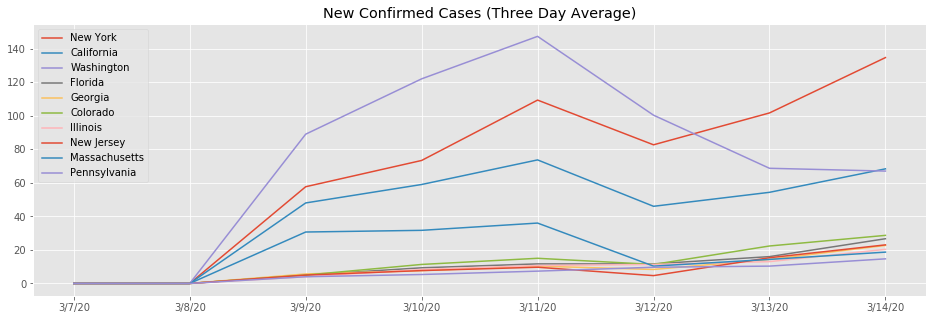

In [17]:
ax = new_daily_cases_US.rolling(3, center=True, axis=1).mean().iloc[:10, 44:].T.plot()

ax.legend(loc='upper left')
ax.set_title('New Confirmed Cases (Three Day Average)')

plt.show()

## Worldwide

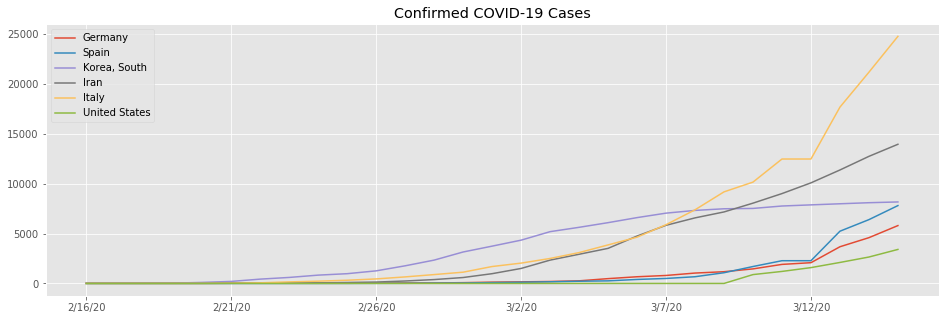

In [18]:
ax = by_country.iloc[:5, 25:][::-1].T.plot()


plt.plot(by_state.sum()[25:], label='United States')

ax.set_title('Confirmed COVID-19 Cases')
ax.legend(loc='upper left')
plt.savefig('covid-by-country.png', dpi=300)
plt.show()